## Section 2: Network Analysis

In [1]:
import pickle
import os
import matplotlib.pyplot as plt
import urllib
import urllib as ul
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import json
import networkx as nx
import ast
from prettytable import PrettyTable
import gseapy as gp
from palettable import wesanderson

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')

### 0. Load Datasets

- Three networks from Section 1.
    - Gene correlation network
    - Patient network from TCGA gene expression data
    - Patient network from TCGA DNA methylation data


In [2]:
print(os.getcwd())

/Users/chaeeunlee/Documents/VSC_workspaces/ismb_public/Section 3


In [3]:
G_patient_gxp_path = 'section2_data/section1_networks/patient_coexpression_network.gml'
G_patient_dnam_path = 'section2_data/section1_networks/patient_meth_network.gml'
G_gxp_path = 'section2_data/section1_networks/gene_coexpression_network.gml' 

# Load the GML graphs
G_gxp = nx.read_gml(G_gxp_path)
G_patient_gxp = nx.read_gml(G_patient_gxp_path)
G_patient_dnam = nx.read_gml(G_patient_dnam_path)

# Get all nodes in the graph
G_gxp_nodes_list = list(G_gxp.nodes())
G_patient_gxp_nodes_list = list(G_patient_gxp.nodes())
G_patient_dnam_nodes_list = list(G_patient_dnam.nodes())

# Load raw TCGA datasets
tcga_dnam_path = 'section2_data/ISMB_TCGA_DNAm.pkl' 

tcga_gxp_path = 'section2_data/ISMB_TCGA_GE.pkl'
tcga_gxp = pd.read_pickle(tcga_gxp_path)

# tcga_gxp_df = tcga_gxp['datExpr']
tcga_gxp_df = pd.read_csv('section2_data/tcga_ge_df_symbols_t.csv') # dataset with gene symbols 
tcga_gxp_df.set_index('GENES', inplace=True)
tcqa_gxp_meta = tcga_gxp['datMeta']


print(len(G_gxp_nodes_list))
print(len(G_patient_gxp_nodes_list))
print(len(G_patient_dnam_nodes_list))

300
265
232


In [4]:
# Check for overlapping nodes between the patient networks
overlap = set(G_patient_gxp_nodes_list).intersection(set(G_patient_dnam_nodes_list))

# Get the number of overlapping nodes
num_overlap = len(overlap)

print(f"{num_overlap} overlapping nodes between patient networks")

232 overlapping nodes between patient networks


### 1. Molecular Network Analysis with `G_exp`

In [5]:
gene_sets = 'KEGG_2021_Human' # 'MSigDB_Hallmark_2020' 

#### 1.1 Over Representation Analysis (ORA)

##### 1.1.1 ORA before clustering

In [6]:
enr_all_nodes = gp.enrichr(gene_list=G_gxp_nodes_list, gene_sets=[gene_sets], organism='human', outdir=None)

In [7]:
enr_all_nodes.results.head(10) 

Gene_set                                 Term Overlap       P-value  \
0  KEGG_2021_Human              Cell adhesion molecules  32/148  4.963642e-28   
1  KEGG_2021_Human                            Phagosome  29/152  7.718499e-24   
2  KEGG_2021_Human      Staphylococcus aureus infection   24/95  5.021667e-23   
3  KEGG_2021_Human                        Leishmaniasis   21/77  4.634501e-21   
4  KEGG_2021_Human                    Viral myocarditis   18/60  4.647925e-19   
5  KEGG_2021_Human           Hematopoietic cell lineage   21/99  1.392113e-18   
6  KEGG_2021_Human                  Allograft rejection   15/38  3.498581e-18   
7  KEGG_2021_Human            Graft-versus-host disease   15/42  2.114525e-17   
8  KEGG_2021_Human             Type I diabetes mellitus   15/43  3.203949e-17   
9  KEGG_2021_Human  Antigen processing and presentation   18/78  8.383314e-17   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0      9.778376e-26            0                     0   20.158518   
1      7.602722e-22            0                     0   17.032160   
2      3.297562e-21            0                     0   24.040416   
3      2.282492e-19            0                     0   26.403226   
4      1.831283e-17            0                     0   29.875380   
5      4.570771e-17            0                     0   18.934932   
6      9.846007e-17            0                     0   45.027460   
7      5.207019e-16            0                     0   38.348928   
8      7.013088e-16            0                     0   36.977444   
9      1.651513e-15            0                     0   20.893617   

   Combined Score  \
0     1267.370905   
1      906.424701   
2     1234.371891   
3     1236.219058   
4     1261.120325   
5      778.523171   
6     1809.841566   
7     1472.411543   
8     1404.387131   
9      773.433715   

                                                                                                                                                                                                              Genes  
0  CD86;ITGAM;SELPLG;ITGB2;ITGAL;SPN;CDH5;HLA-DMA;HLA-DMB;HLA-DOA;CD34;HLA-DQA1;HLA-DPA1;HLA-DRB5;ITGA4;HLA-B;HLA-C;HLA-A;HLA-F;CD2;VCAN;CD4;PTPRC;CD6;CD8A;ITGA8;PECAM1;HLA-DPB1;HLA-DRA;SIGLEC1;HLA-DRB1;HLA-DQB1  
1                ITGAM;NCF2;NCF4;ITGB2;THBS2;CORO1A;FCGR3A;HLA-DMA;HLA-DMB;MRC1;CD14;HLA-DOA;HLA-DQA1;HLA-DPA1;MSR1;HLA-DRB5;HLA-B;CYBB;HLA-C;TAP1;HLA-A;HLA-F;MARCO;FCGR2A;HLA-DPB1;HLA-DRA;TLR4;HLA-DRB1;HLA-DQB1  
2                                           C1QB;C1QA;HLA-DRB5;ITGAM;SELPLG;ITGB2;C5AR1;PTAFR;FPR1;FPR3;ITGAL;FCGR3A;HLA-DMA;HLA-DMB;FCGR2A;C3AR1;HLA-DPB1;HLA-DRA;HLA-DOA;HLA-DQA1;HLA-DRB1;HLA-DPA1;HLA-DQB1;C1QC  
3                                                             HLA-DRB5;ITGAM;ITGA4;NCF2;PRKCB;STAT1;ITGB2;NCF4;CYBB;FCGR3A;HLA-DMA;HLA-DMB;FCGR2A;HLA-DPB1;HLA-DRA;HLA-DOA;TLR4;HLA-DQA1;HLA-DRB1;HLA-DPA1;HLA-DQB1  
4                                                                              CD86;HLA-DRB5;LAMA2;ITGB2;HLA-B;HLA-C;HLA-A;ITGAL;HLA-F;HLA-DMA;HLA-DMB;HLA-DPB1;HLA-DRA;HLA-DOA;HLA-DQA1;HLA-DRB1;HLA-DPA1;HLA-DQB1  
5                                                                     CSF1R;HLA-DRB5;ITGAM;ITGA4;CD3E;CD2;HLA-DMA;CD4;HLA-DMB;CD8A;HLA-DPB1;HLA-DRA;CD37;CD14;HLA-DOA;IL7R;CD34;HLA-DQA1;HLA-DRB1;HLA-DPA1;HLA-DQB1  
6                                                                                                CD86;HLA-DRB5;HLA-B;HLA-C;HLA-A;HLA-F;HLA-DMA;HLA-DMB;HLA-DPB1;HLA-DRA;HLA-DOA;HLA-DQA1;HLA-DRB1;HLA-DPA1;HLA-DQB1  
7                                                                                                CD86;HLA-DRB5;HLA-B;HLA-C;HLA-A;HLA-F;HLA-DMA;HLA-DMB;HLA-DPB1;HLA-DRA;HLA-DOA;HLA-DQA1;HLA-DRB1;HLA-DPA1;HLA-DQB1  
8                                                                                                CD86;HLA-DRB5;HLA-B;HLA-C;HLA-A;HLA-F;HLA-DMA;HLA-DMB;HLA-DPB1;HLA-DRA;HLA-DOA;HLA-DQA1;HLA-

##### 1.1.1 ORA after clustering

In [8]:
# (Add other clustering methods introduced in Section 1)
communities = nx.algorithms.community.modularity_max.greedy_modularity_communities(G_gxp)

# Print out the number of communities
print(f'The network has {len(communities)} communities.\n')

# Create sub-grpahs of each community
subgraphs = []
for community in communities:
    subgraphs.append(G_gxp.subgraph(community))
    
# Print out the number of nodes in each community
for i, subgraph in enumerate(subgraphs):
    print(f'Community {i+1} has {subgraph.number_of_nodes()} nodes.')

The network has 6 communities.

Community 1 has 101 nodes.
Community 2 has 67 nodes.
Community 3 has 64 nodes.
Community 4 has 51 nodes.
Community 5 has 15 nodes.
Community 6 has 2 nodes.


In [9]:
from matplotlib.patches import Patch

def draw_communities(G, communities, figsize=(10,10), layout='spring', cmap_name='tab20'):
    """
    Draws the graph G with nodes colored by community memberships and includes a legend indicating community index.

    """
    if not G:
        raise ValueError("The graph is empty or not defined.")
    if not communities:
        raise ValueError("Communities list is empty or not defined.")

    # Create a dict with the node as key and community index as value
    community_dict = {node: idx for idx, community in enumerate(communities) for node in community}

    # Determine number of communities and set up colors
    num_communities = len(communities)
    cmap = plt.get_cmap(cmap_name)
    community_colors = [cmap(i / num_communities) for i in range(num_communities)]
    node_colors = [community_colors[community_dict[node]] for node in G.nodes()]

    # Set up the figure
    plt.figure(figsize=figsize)
    pos = getattr(nx, f'{layout}_layout')(G) if hasattr(nx, f'{layout}_layout') else nx.spring_layout(G)

    # Draw the graph
    nx.draw(G, pos, node_color=node_colors, with_labels=True, node_size=1000, font_size=12, width=0.5)

    # Create a legend
    legend_handles = [Patch(facecolor=community_colors[i], label=f'Community {i+1}') for i in range(num_communities)]
    plt.legend(handles=legend_handles, title="Communities")

    plt.show()


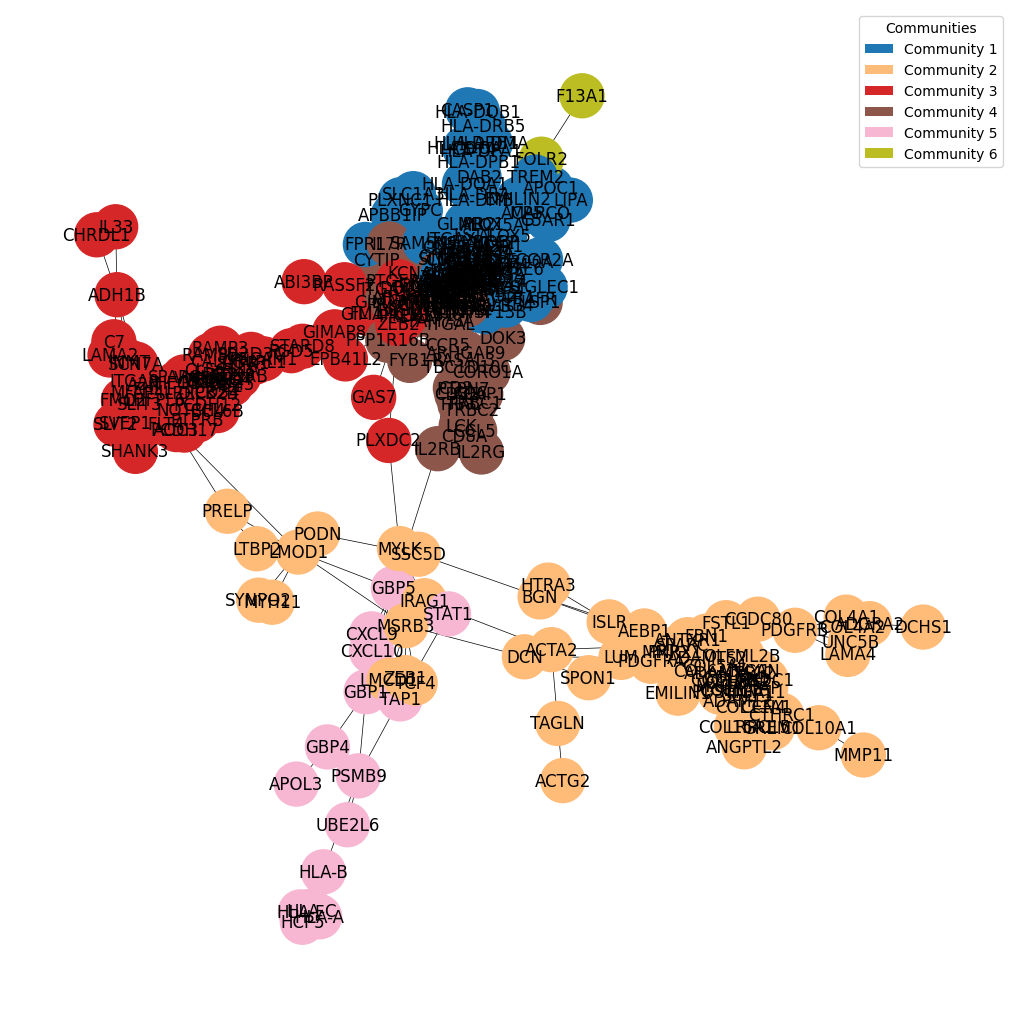

In [10]:
draw_communities(G_gxp, communities)

In [11]:
def communityORA(genes):
    enr = gp.enrichr(gene_list=genes, 
                     gene_sets=[gene_sets],
                     organism='human', 
                     outdir=None, # Do not write to disk
                     )
    return enr

communities = [list(community) for community in communities]

# Perform ORA for three communities
community1_enr = communityORA(communities[0])
community2_enr = communityORA(communities[1])
community3_enr = communityORA(communities[2])

# Print the top 10 results for each community
x = PrettyTable()
x.field_names = ["Community 1", "Community 2", "Community 3"]
for i in range(10):
    x.add_row([community1_enr.results['Term'][i], community2_enr.results['Term'][i], community3_enr.results['Term'][i]])
print(x)

+----------------------------------------------+------------------------------------------------------+-------------------------------------------------+
|                 Community 1                  |                     Community 2                      |                   Community 3                   |
+----------------------------------------------+------------------------------------------------------+-------------------------------------------------+
|       Staphylococcus aureus infection        |           Protein digestion and absorption           |             Cell adhesion molecules             |
|                  Phagosome                   |                    Focal adhesion                    |       Complement and coagulation cascades       |
|                Leishmaniasis                 |               ECM-receptor interaction               |             ECM-receptor interaction            |
|                 Tuberculosis                 |              Relaxin signal

#### 1.2 Gene Set Enrichment Analysis (GSEA)

In [12]:
tcga_gxp_df.head(5)

TCGA-38-7271  TCGA-55-7914  TCGA-95-7043  TCGA-73-4658  TCGA-86-8076  \
GENES                                                                          
TSPAN6       11.3668       11.5434       11.4110       12.2149       11.2882   
DPM1         10.3673       10.5282       11.2018       10.3249       10.2095   
SCYL3         9.7884        9.7292        9.4449        9.2340        9.8186   
FIRRM         8.2552        7.9951        8.3546        7.7537        7.9844   
FGR          10.6173        8.4858        7.3211       11.0656       10.5213   

        TCGA-55-7726  TCGA-44-6147  TCGA-50-5932  TCGA-44-2661  TCGA-86-7954  \
GENES                                                                          
TSPAN6       11.2084       11.1717       12.1281       11.9908       12.2601   
DPM1         11.6034       10.5684       10.5895       10.8699       10.8979   
SCYL3         9.0884       10.2428       10.1989        9.8516        9.7973   
FIRRM         8.7984        8.8721        8.3550        8.1877        9.2347   
FGR           9.3386        9.3440        8.7403       10.6243        9.8945   

        TCGA-73-4662  TCGA-44-7671  TCGA-78-8660  TCGA-62-A46P  TCGA-55-6978  \
GENES                                                                          
TSPAN6       11.6963       11.4364       10.8184       11.5513       11.2016   
DPM1         10.2597       10.2811       10.5428       11.4632       10.4191   
SCYL3        10.4597        9.5387        9.1616        9.6713        9.1914   
FIRRM         9.8346        7.8180        9.0867        7.4249        7.2293   
FGR          10.1067        8.2663       10.5393        9.3087       11.7055   

        TCGA-50-6592  TCGA-38-4625  TCGA-80-5611  TCGA-86-8054  TCGA-55-6986  \
GENES                                                                          
TSPAN6       11.5201       12.3420       11.9378       12.6268       12.3495   
DPM1         11.1089       11.7516       11.0717       11.3598       10.5437   
SCYL3         9.1989        9.0392        9.7859        9.5704        9.3099   
FIRRM         9.1192       10.0768        9.4085       10.0984        7.4506   
FGR          10.1633        9.9218       10.7935        8.6680        9.3646   

        TCGA-L9-A5IP  TCGA-69-7764  TCGA-49-6744  TCGA-75-5125  TCGA-38-4626  \
GENES                                                                          
TSPAN6       10.0858       10.1934       11.4793       11.8151       10.9083   
DPM1         10.1693       10.4140       10.5354       10.7697       11.1321   
SCYL3         9.9071       10.2033        9.4620        8.8882        8.9993   
FIRRM         9.3028        8.9049        8.0116        8.5089        7.1778   
FGR           8.4917        8.3683       10.5502       10.4143       13.7653   

        TCGA-69-7763  TCGA-86-8279  TCGA-93-8067  TCGA-97-8179  TCGA-55-A48Y  \
GENES                                                                          
TSPAN6       10.9789       12.3310       11.0959       12.2844       12.2692   
DPM1         10.9468       11.0926       10.7382       10.8152       10.3957   
SCYL3         9.2914       10.1648        9.6722        9.8902        9.5831   
FIRRM         7.2466        9.0061        8.9549        9.0305        8.8959   
FGR           9.8602        8.9363        9.0198        9.2149        9.1690   

        TCGA-86-8055  TCGA-91-6835  TCGA-55-6982  TCGA-55-A4DF  TCGA-44-6774  \
GENES                                                                          
TSPAN6       12.4793       11.6572       10.4046       11.7654       11.5185   
DPM1         10.4709       10.1559        9.9805       11.4481       10.4410   
SCYL3         9.6185        9.3662        9.4164        9.3445        9.0884   
FIRRM         8.5437        7.0665        7.0667        9.0817        8.4102   
FGR           9.9654       10.4230       11.6101       10.4511        9.6184   

        TCGA-50-5066  TCGA-05-5423  TCGA-67-3774  TCGA-97-A4M2  TCGA-95-7567  \
G

In [13]:
classes = {}

for sample in tcga_gxp_df.loc[G_gxp_nodes_list].columns: # loc grabs rows of specified gene symbols
    if tcqa_gxp_meta.loc[sample, 'Smoked']=='Smoker':
        classes[sample]='smoker'
    elif tcqa_gxp_meta.loc[sample, 'Smoked']=='Never':
        classes[sample]='control'
    else:
        pass

In [14]:
# Perform GSEA
gs_res = gp.gsea(data=tcga_gxp_df.loc[G_gxp_nodes_list], gene_sets=gene_sets, cls=classes, permutation_num=100, outdir=None, method='signal_to_noise', threads=4, seed=7)
gs_res.res2d.head()

Name                                     Term        ES       NES  \
0  gsea                            Toxoplasmosis  0.672196   1.87385   
1  gsea                              Influenza A  0.708245    1.7236   
2  gsea                Th17 cell differentiation  0.735164  1.659187   
3  gsea         Th1 and Th2 cell differentiation  0.735164  1.659187   
4  gsea  Human T-cell leukemia virus 1 infection  0.645243  1.649653   

  NOM p-val FDR q-val FWER p-val  Tag %  Gene %  \
0  0.017544  0.131839       0.05  11/19  14.33%   
1  0.117647  0.477917       0.11  11/17  14.33%   
2  0.096154  0.399637       0.18  10/16  14.33%   
3  0.096154  0.399637       0.18  10/16  14.33%   
4  0.083333  0.323006       0.18  13/22  18.67%   

                                                                                               Lead_genes  
0             HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;HLA-DPA1;HLA-DQB1;HLA-DQA1;HLA-DRB5;ALOX5;HLA-DOA  
1             HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;CASP1;HLA-DPA1;HLA-DQB1;HLA-DQA1;HLA-DRB5;HLA-DOA  
2                   HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;HLA-DPA1;HLA-DQB1;HLA-DQA1;HLA-DRB5;HLA-DOA  
3                   HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;HLA-DPA1;HLA-DQB1;HLA-DQA1;HLA-DRB5;HLA-DOA  
4  HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;HLA-DPA1;HLA-DQB1;HLA-DQA1;HLA-DRB5;SPI1;HLA-DOA;ITGB2;HLA-F

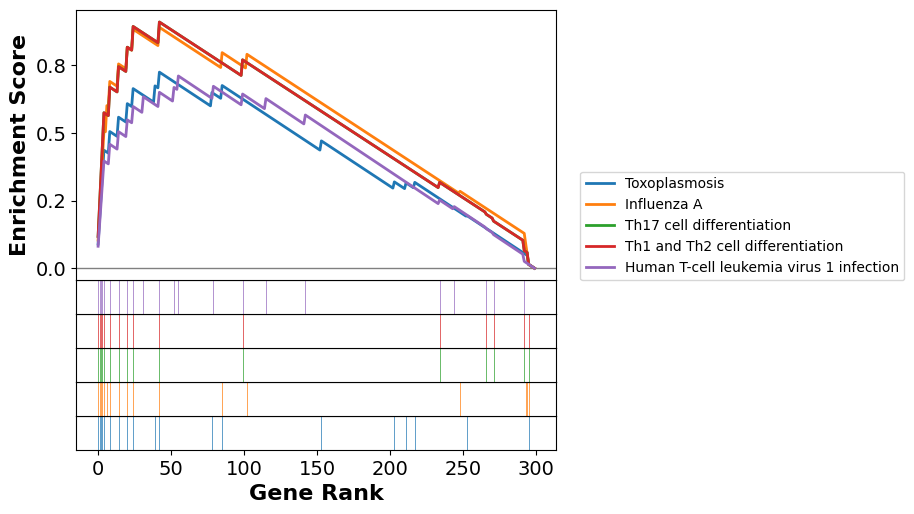

In [15]:
terms = gs_res.res2d.Term
axs = gs_res.plot(terms[:5], show_ranking=False, legend_kws={'loc': (1.05, 0)}, )

In [16]:
gs_res.res2d.Lead_genes

0                                                          HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;HLA-DPA1;HLA-DQB1;HLA-DQA1;HLA-DRB5;ALOX5;HLA-DOA
1                                                          HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;CASP1;HLA-DPA1;HLA-DQB1;HLA-DQA1;HLA-DRB5;HLA-DOA
2                                                                HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;HLA-DPA1;HLA-DQB1;HLA-DQA1;HLA-DRB5;HLA-DOA
3                                                                HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;HLA-DPA1;HLA-DQB1;HLA-DQA1;HLA-DRB5;HLA-DOA
4                                               HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;HLA-DPA1;HLA-DQB1;HLA-DQA1;HLA-DRB5;SPI1;HLA-DOA;ITGB2;HLA-F
5                                                HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;HLA-DPA1;NCF4;NCF2;HLA-DQB1;HLA-DQA1;HLA-DRB5;HLA-DOA;ITGB2
6         HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;HLA-DPA1;NCF4;NCF2;HLA-DQB1;HLA-DQA1;HLA-D

[]

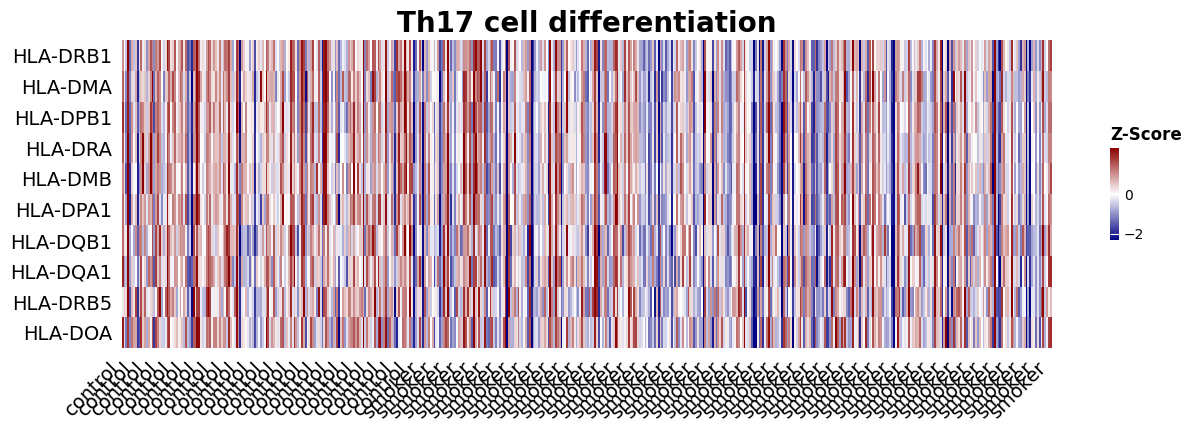

In [17]:
from gseapy import heatmap

i = 2
genes = gs_res.res2d.Lead_genes[i].split(";")

ax = heatmap(df=gs_res.heatmat.loc[genes], z_score=0, title=terms[i], figsize=(15,4))
xtick_labels = [classes[item.get_text()] for item in ax.get_xticklabels()]

ax.set_xticklabels(xtick_labels, rotation=45, ha='right')
ax.plot()

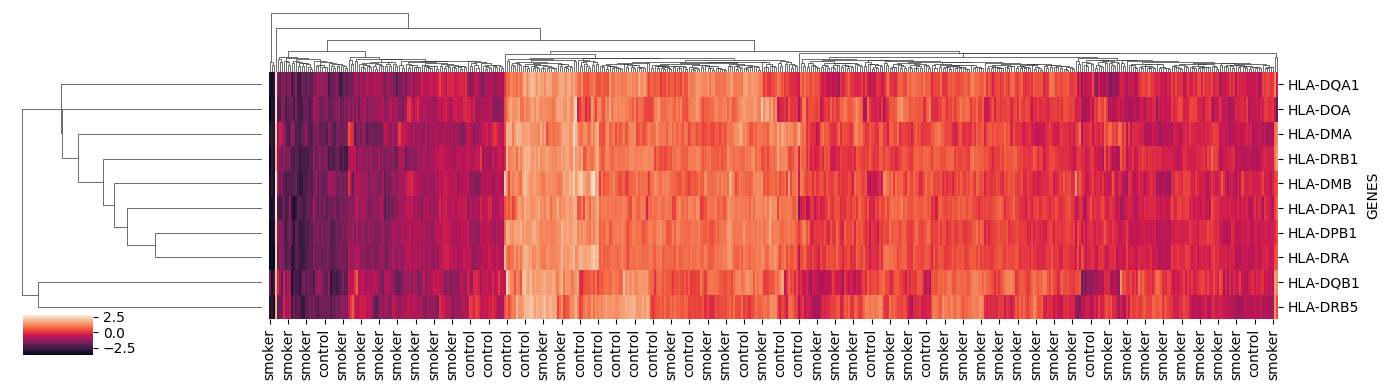

In [18]:
from seaborn import clustermap

i = 2

genes = gs_res.res2d.Lead_genes[i].split(";")
data = gs_res.heatmat.loc[genes]
data.rename(columns=classes, inplace=True)

ax = clustermap(
    data = data, # gs_res.heatmat.loc[genes],
    pivot_kws=None,
    method='average',
    metric='euclidean',
    z_score=0,
    figsize=(14, 4),
    dendrogram_ratio=0.2,
    colors_ratio=0.03,
    cbar_pos=(0.02, 0.1, 0.05, 0.1),
    tree_kws=None)

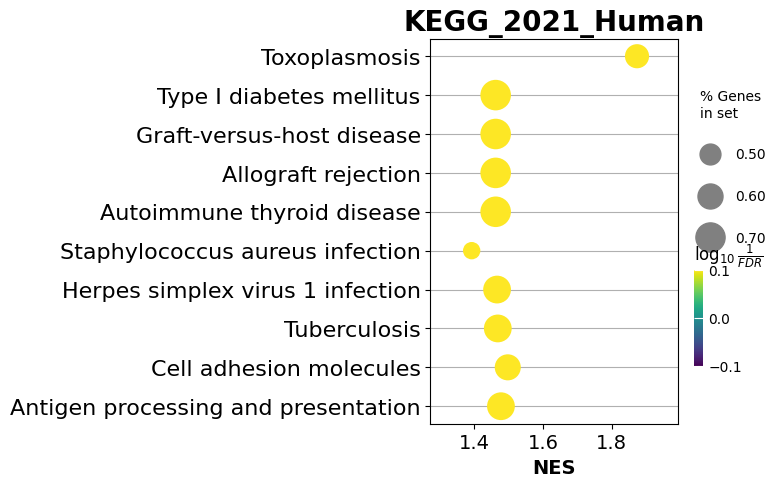

In [19]:
from gseapy import dotplot

ax = dotplot(gs_res.res2d,
             column="FDR q-val",
             title='KEGG_2021_Human',
             cmap=plt.cm.viridis,
             size=5,
             figsize=(4,5), cutoff=1)

#### GSEA on clusters

In [20]:
def communityGSEA(genes, gene_sets='KEGG_2021_Human', classes=classes):

    gs_res = gp.gsea(data=tcga_gxp_df.loc[genes], gene_sets=gene_sets, cls=classes, permutation_num=100, outdir=None, method='signal_to_noise', threads=4, seed=7, min_size=1) 
    return gs_res

# Perform ORA for each community
community1_gsea = communityGSEA(communities[0])
community2_gsea = communityGSEA(communities[1]) 
community3_gsea = communityGSEA(communities[2])

In [21]:
community1_gsea.res2d.head()

Name                          Term        ES       NES NOM p-val FDR q-val  \
0  gsea  Epstein-Barr virus infection  0.853817  1.789511       0.0  0.324881   
1  gsea                 Leishmaniasis  0.667361  1.767749  0.040816  0.181183   
2  gsea                   Influenza A  0.805713  1.723862       0.0  0.191596   
3  gsea                     Phagosome  0.595196  1.717777  0.041667  0.149945   
4  gsea       Cell adhesion molecules  0.649813  1.710744      0.04  0.127453   

  FWER p-val  Tag %  Gene %  \
0       0.14  10/11  16.83%   
1       0.17  11/18  16.83%   
2        0.2  10/12  16.83%   
3       0.21  16/22  34.65%   
4       0.22  10/16  16.83%   

                                                                                                              Lead_genes  
0                                      HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;HLA-DPA1;HLA-DQB1;HLA-DQA1;BTK;HLA-DRB5  
1                                HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;HLA-DPA1;NCF4;NCF2;HLA-DQB1;HLA-DQA1;HLA-DRB5  
2                                    HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;CASP1;HLA-DPA1;HLA-DQB1;HLA-DQA1;HLA-DRB5  
3  HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;HLA-DPA1;NCF4;NCF2;HLA-DQB1;HLA-DQA1;HLA-DRB5;MSR1;HLA-DOA;MARCO;ITGB2;MRC1  
4                                   HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;HLA-DPA1;HLA-DQB1;SELPLG;HLA-DQA1;HLA-DRB5

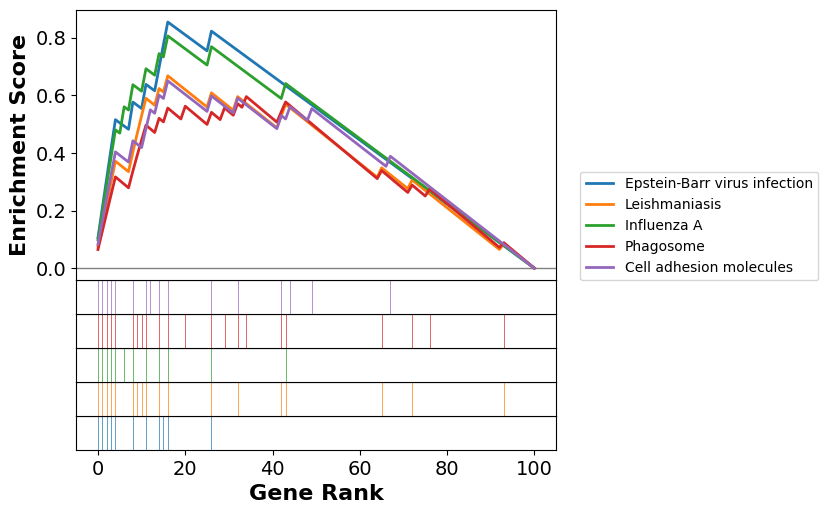

In [22]:
terms = community1_gsea.res2d.Term
axs = community1_gsea.plot(terms[:5], show_ranking=False, legend_kws={'loc': (1.05, 0)}, )

### 2. Patient Network Analysis

#### 2.1 Clustering on Individual Patient Networks

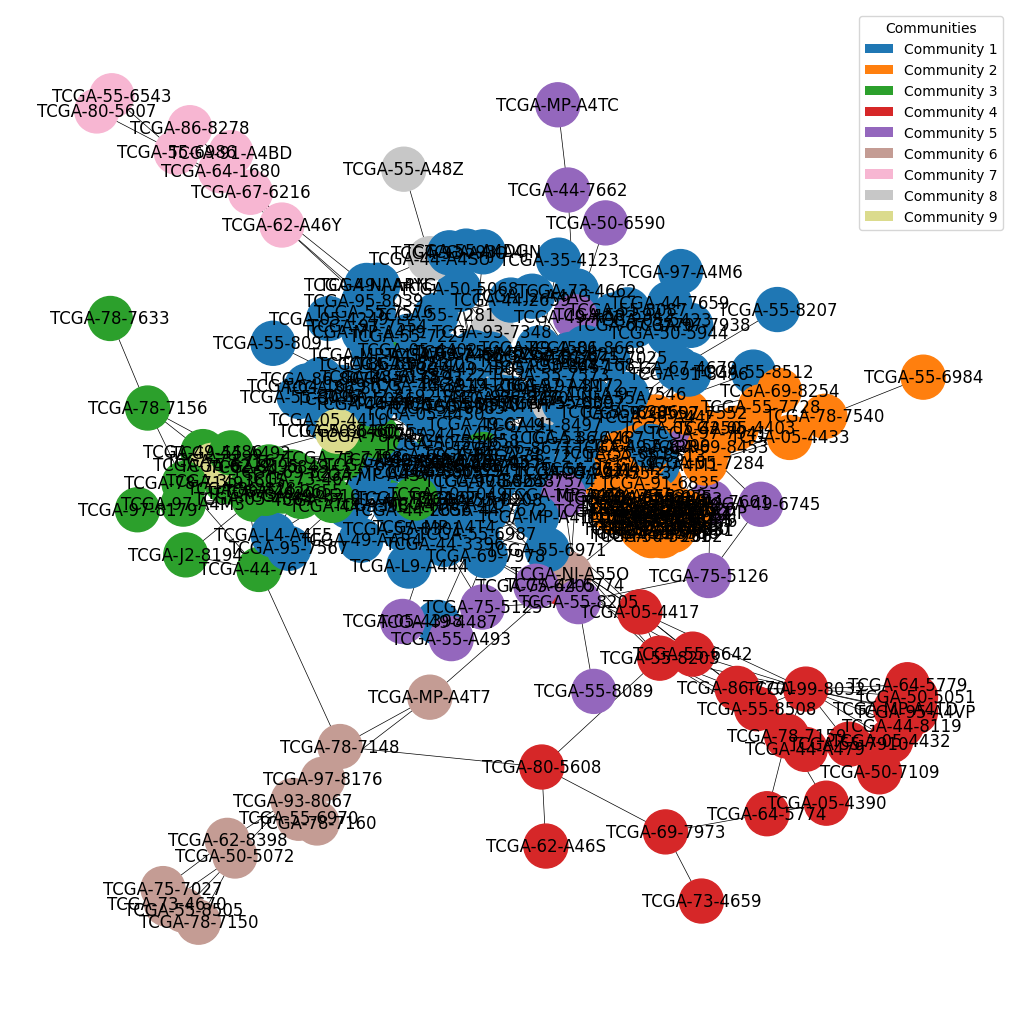

In [23]:
patient_gxp_communities = nx.algorithms.community.modularity_max.greedy_modularity_communities(G_patient_gxp)
draw_communities(G_patient_gxp, patient_gxp_communities)

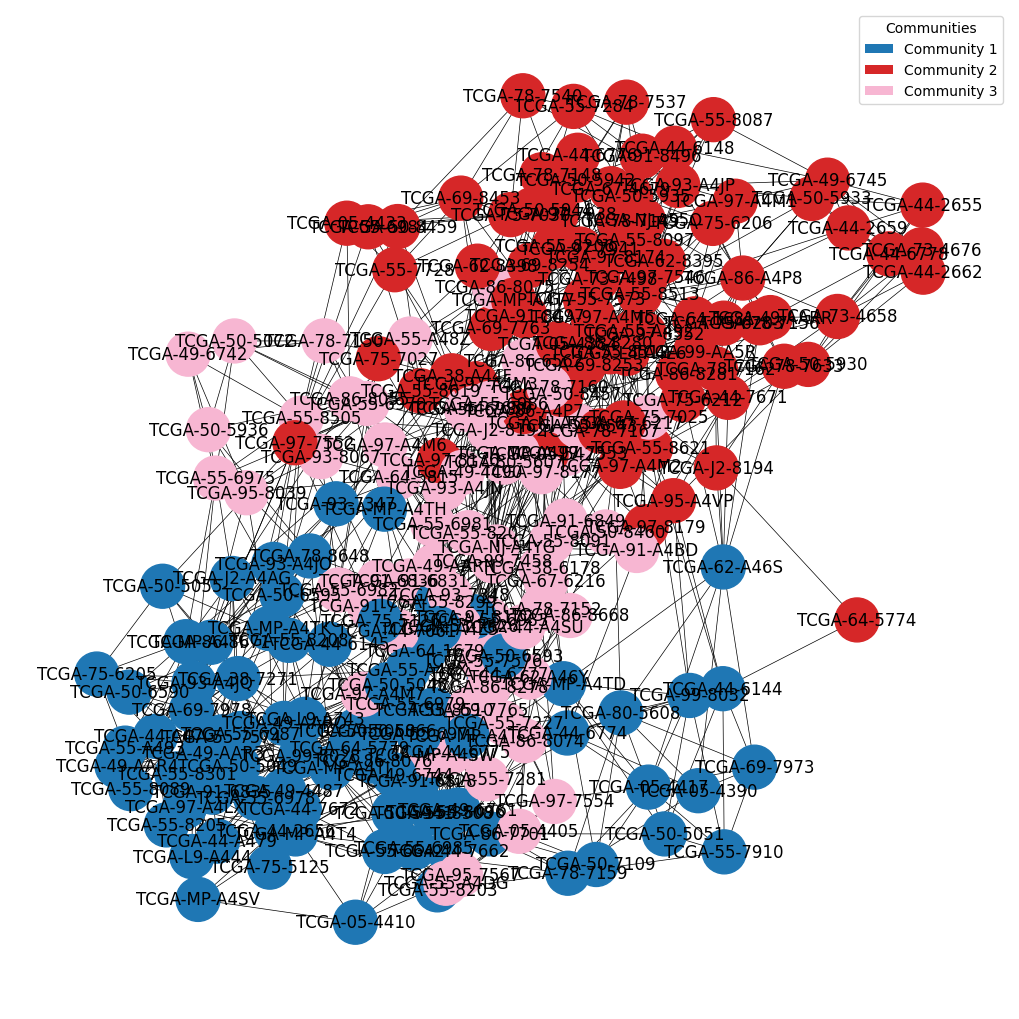

In [24]:
patient_dnam_communities = nx.algorithms.community.modularity_max.greedy_modularity_communities(G_patient_dnam)
draw_communities(G_patient_dnam, patient_dnam_communities)

#### 2.2 Similarity Network Fusion (SNF)

In [25]:
import snf

In [26]:
def get_k_neighbors(matrix, k):
    k_neighbors = {}
    for node in matrix.index:
        neighbors = matrix.loc[node].nlargest(k + 1).index.tolist()[1:]  # Exclude the node itself
        k_neighbors[node] = neighbors
    return k_neighbors

def plot_knn_network(data, K, labels,  node_colours='skyblue', node_size=300): 

    # Get k-nearest neighbors for each node (k=20 in this example)
    k_neighbors = get_k_neighbors(data, k=K)

    # Create a NetworkX graph
    G = nx.Graph()

    # Add nodes to the graph
    G.add_nodes_from(data.index)

    # Add edges based on the k-nearest neighbors
    for node, neighbors in k_neighbors.items():
        for neighbor in neighbors:
            G.add_edge(node, neighbor)

    plt.figure(figsize=(10, 8))
    nx.draw(G, with_labels=False, font_weight='bold', node_size=node_size, node_color=node_colours, font_size=8)
    patches = []
    for col , lab in zip(node_colours.unique() , labels) : 
        patches.append(matplotlib.patches.Patch(color=col, label=lab)) # mpatches
    plt.legend(handles=patches)
    plt.show()
    
    return G, k_neighbors

In [27]:
# # Get adjacency matrices
# G_patient_gxp_adj_matrix = nx.to_pandas_adjacency(G_patient_gxp, weight='weight')
# G_patient_dnam_adj_matrix = nx.to_pandas_adjacency(G_patient_dnam, weight='weight')

# Get overlapping nodes
all_idx = list(set(G_patient_gxp_nodes_list) & set(G_patient_dnam_nodes_list))

# Create adjacency matrix for G_patient_gxp with overlapping nodes
G_patient_gxp_adj_matrix = nx.to_pandas_adjacency(G_patient_gxp, nodelist=all_idx, weight='weight')

# Create adjacency matrix for G_patient_dnam with overlapping nodes
G_patient_dnam_adj_matrix = nx.to_pandas_adjacency(G_patient_dnam, nodelist=all_idx, weight='weight')

In [28]:
full_graphs = [] # list of adjacency matrices
full_graphs.append(G_patient_gxp_adj_matrix)
full_graphs.append(G_patient_gxp_adj_matrix)

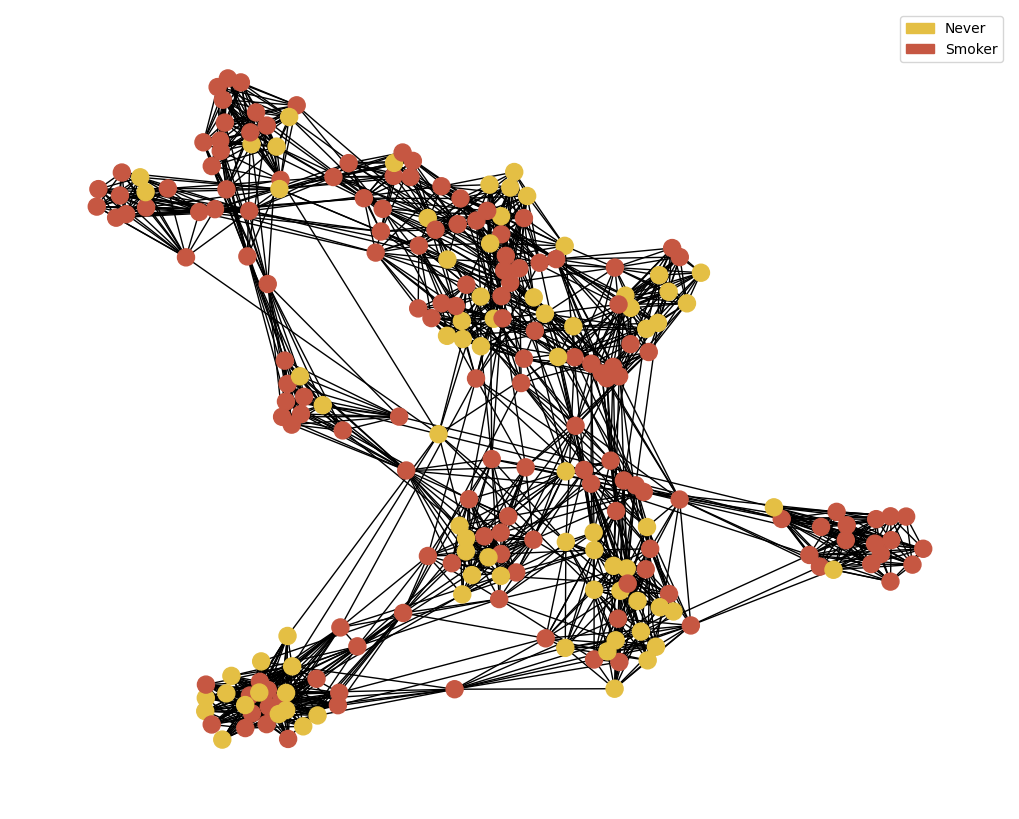

In [29]:
k = 12
adj = snf.snf(full_graphs, K=k, t=10) 
adj_snf = pd.DataFrame(data=adj, index=all_idx, columns=all_idx)

node_labels = pd.Series(adj_snf.index) 
node_colour = tcqa_gxp_meta.loc[adj_snf.index]["Smoked"].astype('category').cat.set_categories(wesanderson.FantasticFox2_5.hex_colors, rename=True)

G_snf, k_neighbors = plot_knn_network(pd.DataFrame(adj) , k, tcqa_gxp_meta.loc[adj_snf.index]["Smoked"].drop_duplicates(), node_colours=node_colour , node_size=150)

network = nx.to_pandas_edgelist(G_snf)
network.columns = ['from' , 'to']
network['from_name'] = [node_labels[i] for i in network['from']]
network['to_name'] = [node_labels[i] for i in network['to']]

# network.to_csv()

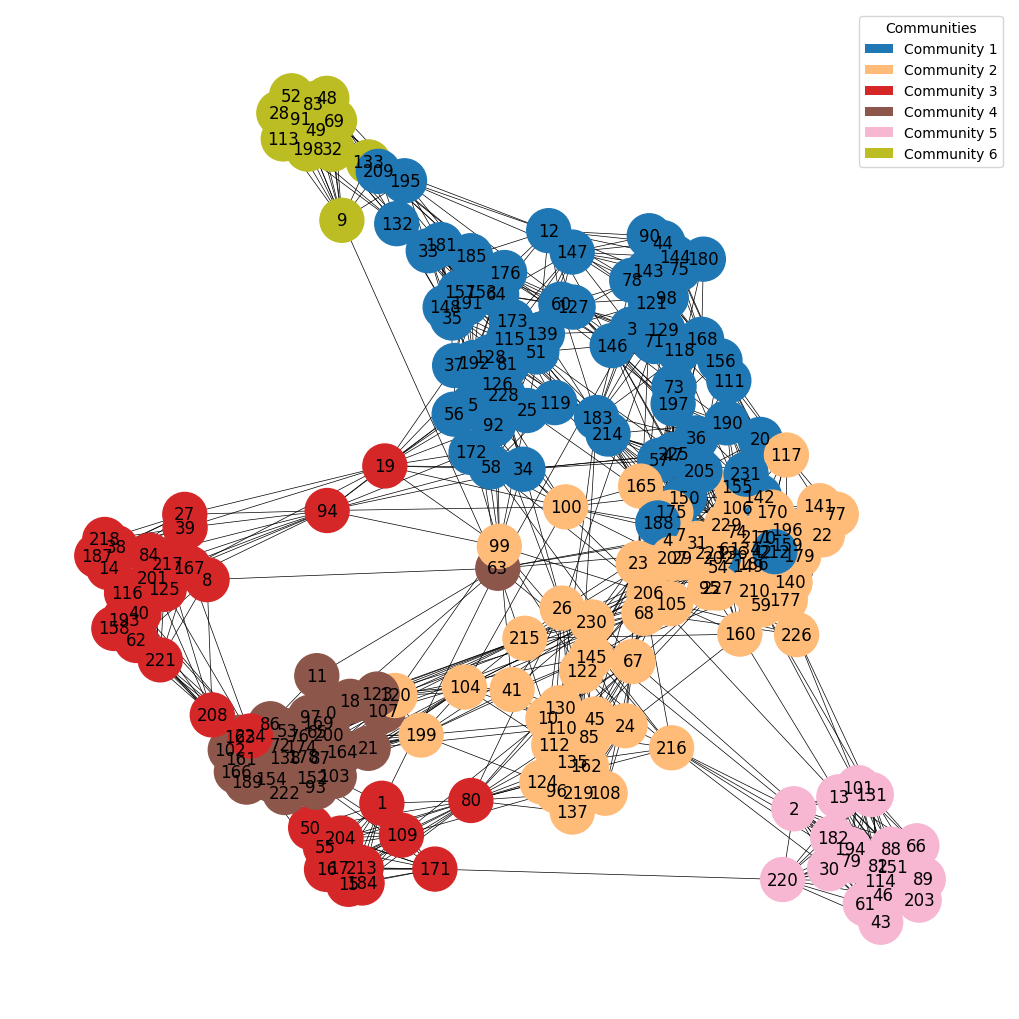

In [41]:
snf_communities = nx.algorithms.community.modularity_max.greedy_modularity_communities(G_snf)
draw_communities(G_snf, snf_communities)

### Optional: GSEA pre-rank with DNA methylation data

### Optional: Create Protein-Protein Interaction (PPI) Network

In [33]:
ewas_smoking = pd.read_csv('section2_data/smoking.tsv' , delimiter='\t') # https://www.ewascatalog.org/?trait=smoking
ewas_smoking.columns

gen_scot = pd.read_pickle('/Users/chaeeunlee/Documents/VSC_workspaces/ismb_2024_data/ISMB_GS_Data.pkl')

In [34]:
ewas_smoking = ewas_smoking[['cpg', 'gene']] # Select only the 'cpg' and 'gene' columns.
ewas_smoking = ewas_smoking[ewas_smoking['gene'] != '-'] # Filter out rows with invalid gene names.
ewas_smoking = ewas_smoking.drop_duplicates() # Remove duplicate rows from the dataframe to ensure each CpG site-gene pair is unique.
ewas_smoking = ewas_smoking.set_index('cpg') # Set the 'cpg' column as the index.



In [35]:
# Load and drop missing values from DNA methylation data w1 and w3 -> two diff batches
w1 = gen_scot['DNAm_w1'].dropna()
w3 = gen_scot['DNAm_w3'].dropna()
phenotypes = gen_scot['Phenotypes']

# Identify common CpG sites present in both GenScot W1 and W3 data and another EWAS smoking dataset.
common_cpg = list(set(w1.index) & set(w3.index) & set(ewas_smoking.index))
w1 = w1.loc[common_cpg]  # Filter W1 data to include only common CpG sites.
w3 = w3.loc[common_cpg]  # Filter W3 data similarly.
ewas_smoking = ewas_smoking.loc[common_cpg]  # Filter EWAS smoking data similarly.

# Helper function to categorize smoking status based on pack_years. -> explain pack_years, examples
def smoking_cat(pack_years):
    if pack_years == 0: # maybe a diff threshold
        return 'Never'
    else:
        return 'Smoker'

# Apply to GenScot phenotypes data.
phenotypes['Smoking'] = phenotypes['pack_years'].apply(smoking_cat)

# Prepare phenotype data for W1 cohort.
phenotypes_w1 = phenotypes.set_index('Sample_SentrixID') 
phenotypes_w1 = phenotypes_w1[phenotypes_w1['Smoking'].notna()]  # Drop entries without smoking data.
phenotypes_w1 = phenotypes_w1[phenotypes_w1['Set'] == 'W1']  # Select only entries from W1 set.

# Align W1 methylation data and W1 phenotype data on common indices.
common_idx = list(set(w1.columns) & set(phenotypes_w1.index))
w1 = w1.loc[:, common_idx]  # Select common columns for W1 methylation data.
phenotypes_w1 = phenotypes_w1.loc[common_idx]  # Select common indices for W1 phenotypes.

# Prepare phenotype data for W3 cohort similarly.
phenotypes_w3 = phenotypes.set_index('Sample_SentrixID')
phenotypes_w3 = phenotypes_w3[phenotypes_w3['Smoking'].notna()]
phenotypes_w3 = phenotypes_w3[phenotypes_w3['Set'] == 'W3']

# Align W3 methylation data and W3 phenotype data on common indices.
common_idx = list(set(w3.columns) & set(phenotypes_w3.index))
w3 = w3.loc[:, common_idx]
phenotypes_w3 = phenotypes_w3.loc[common_idx]


#### Retrieve PPI data from StringDB

In [36]:
def get_PPIs(identifiers, qtype="get_network"):
    
    identifiers = '%0D'.join(map(str, identifiers))  # Concatenate using '%0D' for the API query.
    query_templates = {
        # "get_string_id": f"https://string-db.org/api/tsv-no-header/get_string_ids?identifiers={identifiers}&species=9606&format=only-ids",
        "get_network": f"https://string-db.org/api/tsv/network?identifiers={identifiers}&species=9606",
        # "get_annotation": f"https://string-db.org/api/json/functional_annotation?identifiers={identifiers}", # &[optional_parameters]"
    }
    
    query_url = query_templates[qtype]
    result = ul.request.urlopen(query_url).read().decode('utf-8').splitlines()
    
    return result

def get_stringdb_ids(identifiers, return_list=False):
    
    identifiers = '%0D'.join(map(str, identifiers)) # Concatenate using '%0D' for the API query.
    query_url = f"https://string-db.org/api/tsv-no-header/get_string_ids?identifiers={identifiers}&species=9606&format=only-ids"
    result = ul.request.urlopen(query_url).read().decode('utf-8').splitlines()
    # result = '%0D'.join(result)
    
    return result if return_list else '%0D'.join(result)

In [37]:
# PPIs related to the genes of interest derived from the EWAS smoking data.
PPIs_df = pd.DataFrame()

# The genes are grouped, sorted by frequency, and the top 400 are selected.
ewas_smoking_genes = list(ewas_smoking.groupby('gene').size().sort_values(ascending=False).iloc[:200].index)

# Get String-DB IDs for the list of gene names.
stringdb_ids = get_stringdb_ids(ewas_smoking_genes, return_list=True)

# Retrieve PPI data using the String-DB IDs.
interactions = get_PPIs(stringdb_ids, qtype="get_network")
interactions = [interaction.split('\t') for interaction in interactions] # Process the interaction data.

# Extract column names and create a DataFrame.
column_names = interactions[0]  # Assuming the first line contains header information.
interactions_df = pd.DataFrame(interactions[1:], columns=column_names)  # Exclude header from data rows.

# Remove any duplicate rows and reset the DataFrame index.
interactions_df.drop_duplicates(inplace=True)
interactions_df.reset_index(drop=True, inplace=True)

# Concatenate with any existing interactions DataFrame to accumulate results.
PPIs_df = pd.concat([PPIs_df, interactions_df], ignore_index=True)

# Display the top rows of the protein-protein interaction table.
display(PPIs_df.head())
display(PPIs_df.info())


stringId_A            stringId_B preferredName_A preferredName_B  \
0  9606.ENSP00000206513  9606.ENSP00000496959           CEBPE           ITGAM   
1  9606.ENSP00000206513  9606.ENSP00000368632           CEBPE           GATA3   
2  9606.ENSP00000206513  9606.ENSP00000345344           CEBPE            CTSL   
3  9606.ENSP00000206513  9606.ENSP00000294702           CEBPE            GFI1   
4  9606.ENSP00000206513  9606.ENSP00000254066           CEBPE            RARA   

  ncbiTaxonId  score nscore fscore pscore ascore escore dscore tscore  
0        9606  0.455      0      0      0  0.123  0.048      0    0.4  
1        9606  0.473      0      0      0      0  0.091      0  0.444  
2        9606  0.528      0      0      0  0.104      0      0  0.495  
3        9606  0.638      0      0      0  0.126  0.091      0  0.581  
4        9606  0.863      0      0      0  0.057  0.045   0.75  0.465

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272 entries, 0 to 271
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   stringId_A       272 non-null    object
 1   stringId_B       272 non-null    object
 2   preferredName_A  272 non-null    object
 3   preferredName_B  272 non-null    object
 4   ncbiTaxonId      272 non-null    object
 5   score            272 non-null    object
 6   nscore           272 non-null    object
 7   fscore           272 non-null    object
 8   pscore           272 non-null    object
 9   ascore           272 non-null    object
 10  escore           272 non-null    object
 11  dscore           272 non-null    object
 12  tscore           272 non-null    object
dtypes: object(13)
memory usage: 27.8+ KB


None

In [38]:
# Make sure PPIs returned from String-DB correspond to the genes in the EWAS smoking data.
gene_set = set(ewas_smoking['gene'])

mask = PPIs_df.apply(lambda row: (row['preferredName_A'] in gene_set) and (row['preferredName_B'] in gene_set), axis=1)
PPIs_df = PPIs_df[mask]

PPIs_df.reset_index(drop=True, inplace=True)

#### Create PPI Network

In [39]:
import networkx as nx  # Import the networkx library to handle graph operations

# Create an empty graph
G = nx.Graph()

# Add nodes to the graph
# We extract unique names from both 'preferredName_A' and 'preferredName_B' and add them as nodes in the graph.
nodes = set(PPIs_df['preferredName_A']).union(set(PPIs_df['preferredName_B']))
G.add_nodes_from(nodes)

# Add edges to the graph
# We create a list of tuples where each tuple represents a connection (edge) between two nodes.
edges = list(zip(PPIs_df['preferredName_A'], PPIs_df['preferredName_B']))
G.add_edges_from(edges)  # Add all edges to the network


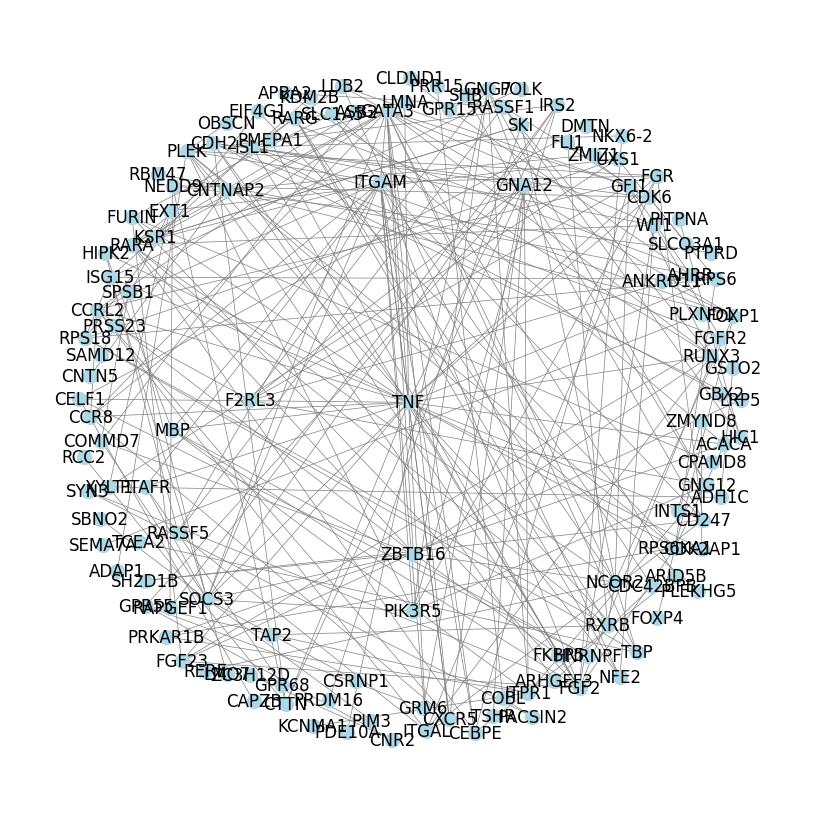

In [40]:
def draw_network(G, figsize=(8, 8)):
    
    plt.figure(figsize=figsize)
    
    pos = nx.spring_layout(G, k=2)  
    nx.draw(G, pos=pos, with_labels=True, node_size=100, edge_color='gray', node_color='lightblue', width=0.5)
    plt.show()

draw_network(G)